# preprocess function

In [19]:
from matplotlib import pyplot as plt
import cv2
import numpy as np

def display(image):
    dpi = 80
    height, width = image.shape[:2]
    scale_factor = 0.2
    width_scaled = width * scale_factor
    height_scaled = height * scale_factor
    
    figsize = width_scaled / float(dpi), height_scaled / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(image, cmap='gray')
    plt.show()
    
def grayscale_conversion(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def thresholding_conversion(gray_image):
    return cv2.threshold(gray_image, 130, 255, cv2.THRESH_BINARY)[1]

def find_edges(thresh_image):
    t_lower = 100
    t_upper = 200
    l2_gradient = True
    return cv2.Canny(thresh_image, t_lower, t_upper, L2gradient=l2_gradient)

def find_angle(edges_image):
    lines = cv2.HoughLines(edges_image, 1, np.pi/180, threshold=200)
    
    angles = []
    for line in lines:
        rho, theta = line[0]
        angle = np.degrees(theta)
        angles.append(angle)
    
    return np.median(angles)

def rotate_image(image, angle):
    center = tuple(np.array(image.shape[1::-1]) / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle-90, 1.0)
    return cv2.warpAffine(image, rotation_matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR)

def crop_drug_label(rotated_image):
    gray = grayscale_conversion(rotated_image)
    thresh = thresholding_conversion(gray)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [max_contour], -1, (255,), thickness=cv2.FILLED)
    # display(mask)
    res = cv2.bitwise_and(thresh, thresh, mask=mask)
    x, y, w, h = cv2.boundingRect(max_contour)
    return res[y:y+h, x:x+w]

def resize_image(image, target_size=(2500, 2000)):
    return cv2.resize(image, target_size)
    
def match_template(image, template):
    result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    
    h, w = template.shape
    top_left = max_loc
    bottom_right = (top_left[0]+w, top_left[1]+h)
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    return top_left[0], top_left[1]

def crop_image(image, coord):
    x, y, w, h = coord[0], coord[1], coord[2], coord[3]
    return image[y:y+h, x:x+w]

def preprocess(image, template):
    gray_image = grayscale_conversion(image)
    thresh_image = thresholding_conversion(gray_image)
    edges = find_edges(thresh_image)
    angle = find_angle(edges)
    rotated = rotate_image(image, angle)
    drug_label = crop_drug_label(rotated)
    resize = resize_image(drug_label)
    
    gray_template_image = grayscale_conversion(template)
    thresh_template_image = thresholding_conversion(gray_template_image)
    x, y = match_template(resize, thresh_template_image)
    
    usage_text = crop_image(resize, (x-100, y+500, 2200, 350))
    drug_name_text = crop_image(resize, (x-100, y+1300, 2200, 200))
    
    display(image)
    display(rotated)
    display(drug_label)
    
    return usage_text, drug_name_text

# OCR

In [20]:
import pytesseract as tess
def ocr(image, config):
    return tess.image_to_string(image, config=config)

# Extract data

In [21]:
import re

def clean_text(text):
    res = ''
    for line in text.splitlines():
        if line == '':
            continue
        res = res + line + ' '
    return res.strip()

def check_period(text):
    keywords = ['เช้า', 'กลางวัน', 'เย็น', 'ก่อนนอน']
    res = {'เช้า': False, 'กลางวัน': False, 'เย็น': False, 'ก่อนนอน': False}
    period_type = False
    
    for keyword in keywords:
        found = re.search(keyword, text)
        if found:
            period_type = True
            res[keyword] = True
    
    if period_type:
        return res
    return None

def check_hour(text):
    pattern = r'.+ ทุกๆ (\d+) (.+)'
    match = re.search(pattern, text)
    
    if match is None:
        return None
    
    num = match.group(1)
    unit = match.group(2)
    return {'num': num, 'unit': unit}

def check_frequency(text):
    keywords = ['วันเว้นวัน']

    for keyword in keywords:
        found = re.search(keyword, text)
        if found:
            return keyword
    return None

def extract_data(drug_name_text, usage_text):
    drug_name = clean_text(drug_name_text)
    usage = clean_text(usage_text)
    print(drug_name, usage)
    res = {'drug_name': drug_name, 'usage': usage, 'notification_type': '', 'notify': [], 'frequency': ''}
    
    freq = check_frequency(usage)
    if freq:
        res['frequency'] = freq
    
    ok = check_period(usage)
    if ok:
        res['notification_type'] = 'period'
        res['notify'] = ok
        return res
    
    ok = check_hour(usage)
    if ok:
        res['notification_type'] = 'hour'
        res['notify'] = ok
        return res
    return None
    

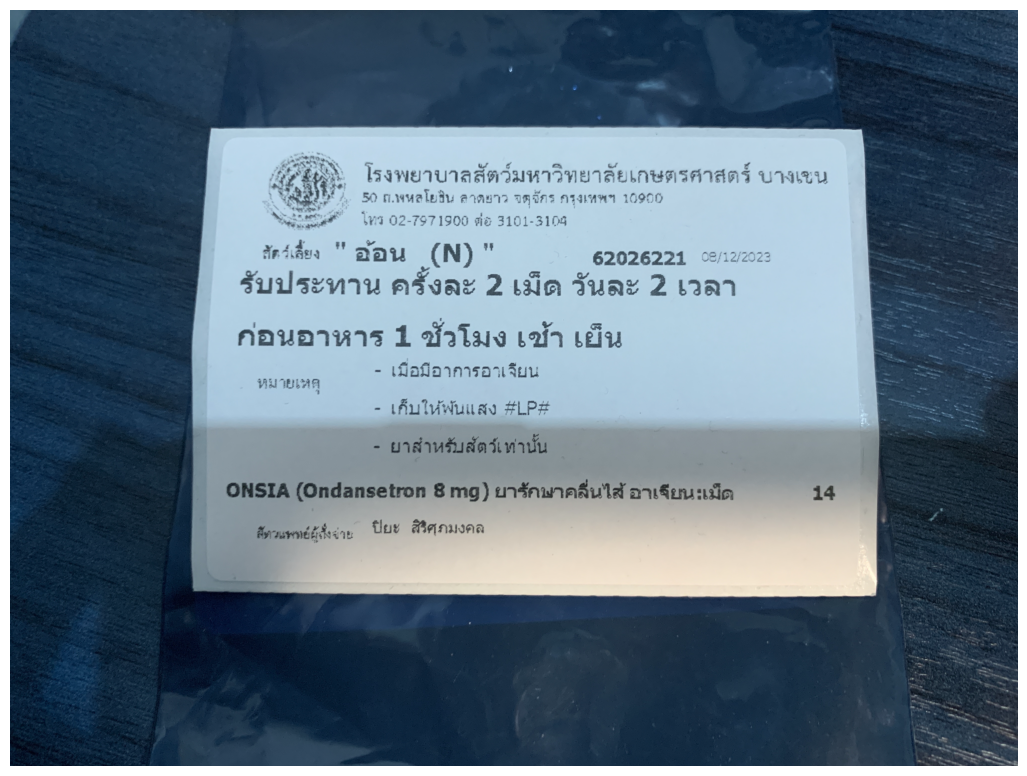

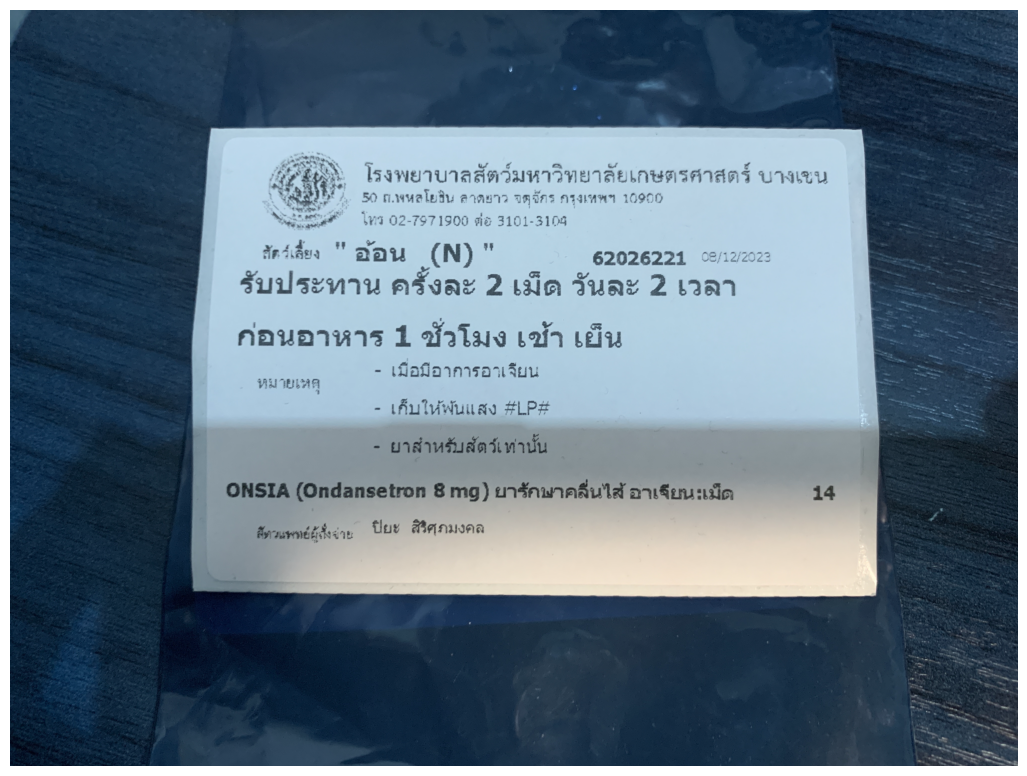

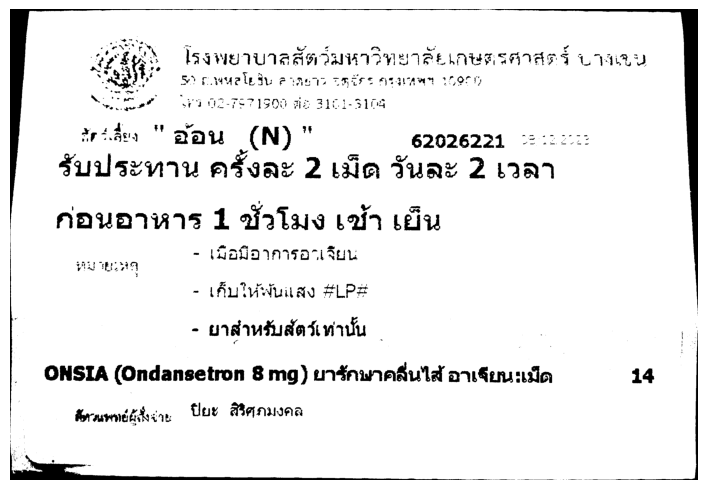

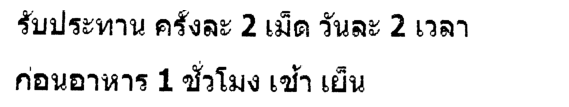

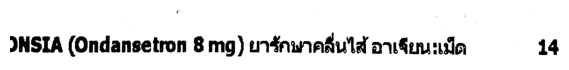

NSIA (Ondansetron 8 mg) ยารักษาคลื่นไส้ อาเจษียน:เม็ด            14 รับประทาน ครั้งละ 2 เม็ด วันละ 2 เวลา ก่อนอาหาร 1 ชั่วโมงเช้า เย็น
{'drug_name': 'NSIA (Ondansetron 8 mg) ยารักษาคลื่นไส้ อาเจษียน:เม็ด            14', 'usage': 'รับประทาน ครั้งละ 2 เม็ด วันละ 2 เวลา ก่อนอาหาร 1 ชั่วโมงเช้า เย็น', 'notification_type': 'period', 'notify': {'เช้า': True, 'กลางวัน': False, 'เย็น': True, 'ก่อนนอน': False}, 'frequency': ''}


In [25]:
image = cv2.imread('./images/img10.JPG')
template = cv2.imread('./images/logo.jpg')
usage_image, drug_name_image = preprocess(image, template)
display(usage_image)
display(drug_name_image)

usage_text = ocr(usage_image, '--oem 3 --psm 6 -l tha')
drug_name_text = ocr(drug_name_image, '--oem 3 --psm 6 -l tha+eng')

res = extract_data(drug_name_text, usage_text)
print(res)